<a href="https://colab.research.google.com/github/PolianaQueiroz/Master-Research-Lab/blob/main/Star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. MONTAR GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')
print("\n✅ Google Drive montado.")

Mounted at /content/drive

✅ Google Drive montado.


In [ ]:
# 2. INSTALAÇÃO DE BIBLIOTECAS
# O pmdarima é necessário para o ARIMA automático. Statsmodels (para Holt-Winters) é geralmente pré-instalado.
!pip install pmdarima

print("\n✅ Bibliotecas instaladas com sucesso.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 15.3 MB/s eta 0:00:00

✅ Bibliotecas instaladas com sucesso.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Configuração de visualização
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
# 2. CARREGAMENTO E PRÉ-PROCESSAMENTO DOS DADOS
# --------------------------------------------------------------------------
# USANDO O CAMINHO DO GOOGLE DRIVE QUE VOCÊ FORNECEU
FILE_NAME = "/content/drive/MyDrive/Trabalho de PPE/star - star.csv"

# Carrega os dados, assumindo que não há cabeçalho
try:
    df = pd.read_csv(FILE_NAME, header=None, names=['Value'])
    print("✅ Arquivo lido como CSV (separador padrão).")
except Exception:
    # Caso a leitura inicial falhe, tenta o formato de separador por ponto e vírgula
    df = pd.read_csv(FILE_NAME, sep=';', header=None, names=['Value'])
    print("✅ Arquivo lido como CSV (separador ';').")

# Cria um índice de data. Assumimos que cada linha representa um dia útil consecutivo ('B')
# A frequência 'B' (Business Day) é usada, assumindo que seus 600 pontos são sequenciais de dias úteis.
num_days = len(df)
start_date = '2022-01-01'
date_range = pd.date_range(start=start_date, periods=num_days, freq='B')
df.index = date_range

print("\n✅ Dados Carregados e Indexados. Primeiras 5 linhas:")
print(df.head())

# Define o ponto de corte para treino e teste (Ex: 80% treino, 20% teste)
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]
forecast_periods = len(test)

✅ Arquivo lido como CSV (separador padrão).

✅ Dados Carregados e Indexados. Primeiras 5 linhas:
            Value
2022-01-03  25.00
2022-01-04  28.00
2022-01-05  31.00
2022-01-06  32.00
2022-01-07  33.00


In [ ]:
# 3. MODELO 1: ARIMA (AUTO_ARIMA)
# --------------------------------------------------------------------------
print("\n🛠️ Treinando Modelo ARIMA...")

# auto_arima busca os melhores parâmetros (p, d, q) que minimizam o AIC.
arima_model = pm.auto_arima(train['Value'],
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            m=1, # Não sazonal
                            d=None,
                            seasonal=False,
                            trace=False,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(f"\n✅ Melhor Parâmetro ARIMA (p, d, q): {arima_model.order}")

# Faz a previsão
arima_forecast = arima_model.predict(n_periods=forecast_periods)
arima_forecast_series = pd.Series(arima_forecast, index=test.index)

# Calcula o erro
arima_rmse = np.sqrt(mean_squared_error(test['Value'], arima_forecast_series))
print(f"📊 RMSE (Raiz do Erro Quadrático Médio) do ARIMA: {arima_rmse:,.2f}")


🛠️ Treinando Modelo ARIMA...

✅ Melhor Parâmetro ARIMA (p, d, q): (5, 0, 4)
📊 RMSE (Raiz do Erro Quadrático Médio) do ARIMA: 13.68


In [ ]:
# 4. MODELO 2: HOLT-WINTERS (EXPONENTIAL SMOOTHING)
# --------------------------------------------------------------------------
print("\n🛠️ Treinando Modelo Holt-Winters...")

# Para dados diários de dias úteis ('B'), 5 é o período de sazonalidade semanal.
# Usando 'add' (aditivo) para tendência e sazonalidade.
hw_model = ExponentialSmoothing(train['Value'],
                                seasonal_periods=5,
                                trend='add',
                                seasonal='add',
                                initialization_method='estimated')

hw_fit = hw_model.fit()

# Faz a previsão
hw_forecast = hw_fit.forecast(forecast_periods)
hw_forecast_series = pd.Series(hw_forecast, index=test.index)

# Calcula o erro
hw_rmse = np.sqrt(mean_squared_error(test['Value'], hw_forecast_series))
print(f"📊 RMSE (Raiz do Erro Quadrático Médio) do Holt-Winters: {hw_rmse:,.2f}")


🛠️ Treinando Modelo Holt-Winters...
📊 RMSE (Raiz do Erro Quadrático Médio) do Holt-Winters: 11.51


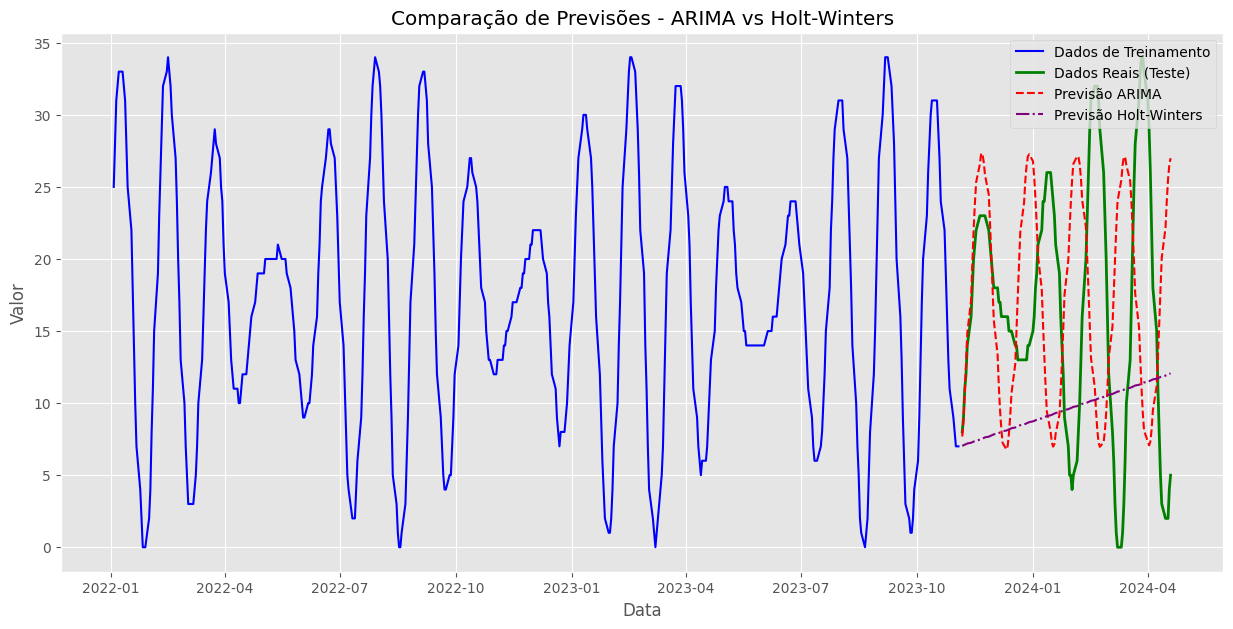


🏆 Resumo da Performance:
RMSE ARIMA: 13.68
RMSE Holt-Winters: 11.51
O modelo Holt-Winters obteve um desempenho ligeiramente melhor (menor RMSE) no período de teste.


In [ ]:
# 5. VISUALIZAÇÃO DOS RESULTADOS
# --------------------------------------------------------------------------
plt.figure(figsize=(15, 7))
plt.title('Comparação de Previsões - ARIMA vs Holt-Winters')
plt.plot(train.index, train['Value'], label='Dados de Treinamento', color='blue')
plt.plot(test.index, test['Value'], label='Dados Reais (Teste)', color='green', linewidth=2)
plt.plot(arima_forecast_series.index, arima_forecast_series, label='Previsão ARIMA', linestyle='--', color='red')
plt.plot(hw_forecast_series.index, hw_forecast_series, label='Previsão Holt-Winters', linestyle='-.', color='purple')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Resumo dos erros
print("\n🏆 Resumo da Performance:")
print(f"RMSE ARIMA: {arima_rmse:,.2f}")
print(f"RMSE Holt-Winters: {hw_rmse:,.2f}")
if arima_rmse < hw_rmse:
    print("O modelo ARIMA obteve um desempenho ligeiramente melhor (menor RMSE) no período de teste.")
else:
    print("O modelo Holt-Winters obteve um desempenho ligeiramente melhor (menor RMSE) no período de teste.")